In [1]:
import numpy as np

import random
import h5py
from keras import backend as K
from keras.models import load_model
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
# external custom code I wrote
from load_data import *
from windowing import *
from nn_util import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE,))

X_train = np.copy(train_processed)

In [5]:
MODEL_FILENAME = './best_coder.h5'

KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization}

autoencoder = load_model(MODEL_FILENAME, KERAS_LOAD_MAP)
K.set_value(QUANTIZATION_ON, True)

/usr/local/lib/python2.7/dist-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [7]:
pre_quant = Model(inputs = encoder.get_input_at(0),
                  outputs = encoder.layers[-1].input)

post_dequant = Model(inputs = decoder.get_input_at(0),
                     outputs = decoder.layers[1].output)

# Analysis

In [8]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 2s     


## Symbol histograms / entropy

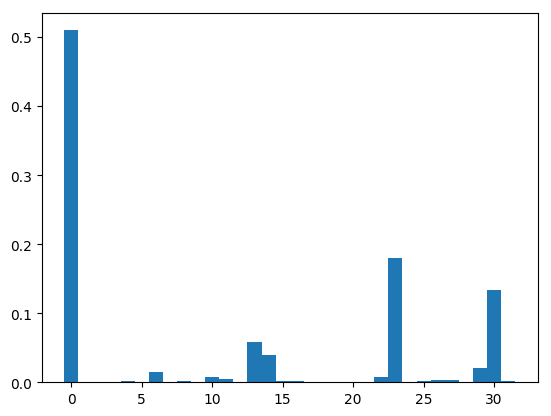

Entropy of distribution: 2.31901234075
[  5.09907067e-01   9.32244642e-04   5.00842034e-05   3.87687556e-04
   2.48994888e-03   3.41485953e-04   1.50285531e-02   8.40886569e-05
   1.36719120e-03   6.08392584e-04   8.26665573e-03   4.78075817e-03
   2.49989826e-04   5.80791906e-02   3.92441228e-02   1.94792787e-03
   1.48866407e-03   4.04602288e-05   7.82942225e-04   4.95362270e-04
   2.01925403e-04   1.06536062e-03   7.66703114e-03   1.79385826e-01
   1.33641035e-04   1.62457884e-03   3.32844234e-03   3.36604076e-03
   6.77617849e-04   2.10634694e-02   1.33732274e-01   1.18100853e-03]
Bins:
[ -2.49855570e-03   1.57958913e+00   2.66322517e+00  -1.56348348e+00
   1.03939545e+00   2.12884545e+00   6.28961444e-01  -2.08434224e+00
   1.29495239e+00   1.81256938e+00  -9.41199839e-01   8.53766203e-01
  -1.70823610e+00  -5.35583258e-01   4.84178722e-01   1.12714326e+00
  -1.28377295e+00  -2.41262603e+00   1.69164622e+00   1.95624769e+00
   2.34485340e+00   1.47612572e+00   7.50097811e-01  -3.0

In [9]:
probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
plt.show()

entropy = 0
for i in hist:
    if (i < 1e-5): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

print hist
print "Bins:"
print K.eval(QUANT_BINS)

In [10]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave)

embed = encoder.predict(windows, batch_size = BATCH_SIZE, verbose = 1)
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

before_quantization = pre_quant.predict(windows, batch_size = BATCH_SIZE, verbose = 1)
after_dequantization = post_dequant.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


Original


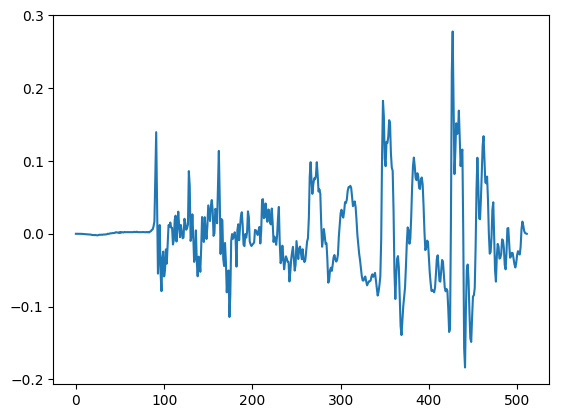

Reconstruction


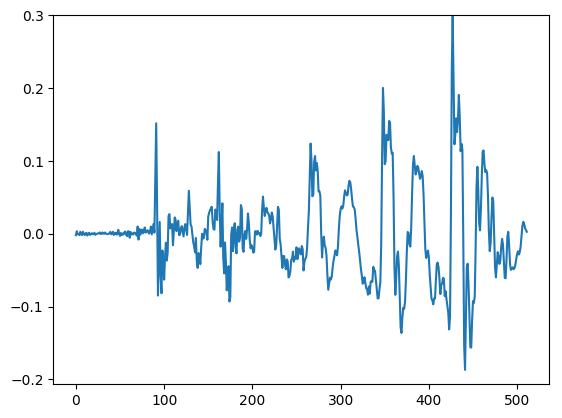

Before quantization


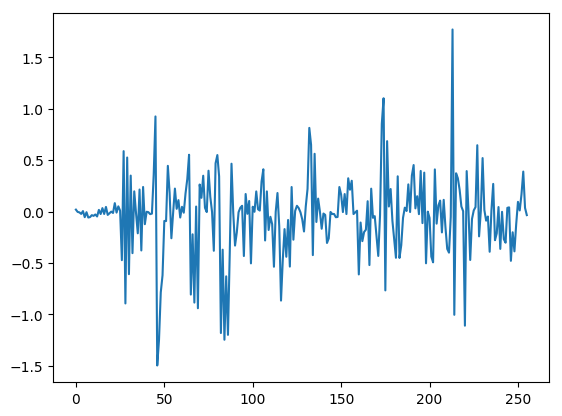

After dequantization


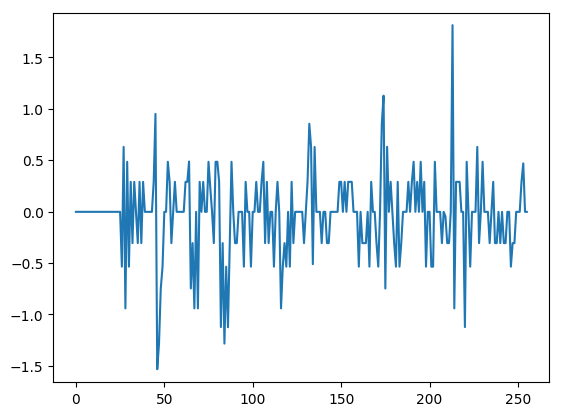

Error


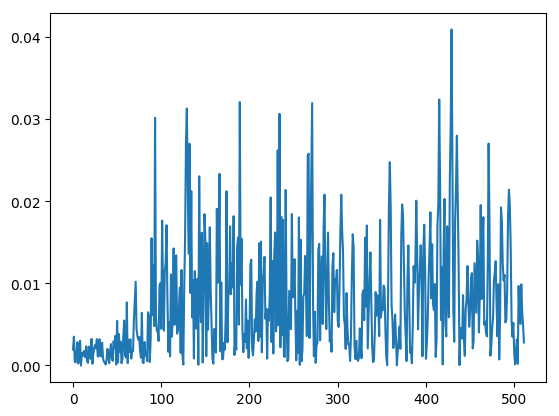

In [11]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Before quantization"
    plt.plot(before_quantization[idx])
    ylim = plt.gca().get_ylim()
    plt.show()

    print "After dequantization"
    plt.plot(after_dequantization[idx])
    plt.ylim(ylim)
    plt.show()
else:
    print "Embedding"
    plt.plot(before_quantization[idx])
    ylim = plt.gca().get_ylim()
    plt.show()

print "Error"
plt.plot(abs(orig - recn))
plt.show()